In [1]:
import gym
import safe_agents as sa
import numpy as np
import skopt
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
env = gym.make('LunarSafe-v0')

In [3]:
"""
s[0] is the horizontal coordinate
s[1] is the vertical coordinate
s[2] is the horizontal speed
s[3] is the vertical speed
s[4] is the angle
s[5] is the angular speed
s[6] 1 if first leg has contact, else 0
s[7] 1 if second leg has contact, else 0

action 1 do nothing
action 2 fire left orientation engine
action 3fire main engine
action 4 fire right orientation engine.
"""

def heuristic(env, s):
    angle_targ = s[0]*0.5 + s[2]*1.0         # angle should point towards center
    if angle_targ > 0.4: angle_targ = 0.4    # more than 0.4 radians (22 degrees) is bad
    if angle_targ < -0.4: angle_targ = -0.4
    hover_targ = 0.55*np.abs(s[0])           # target y should be proportional to horizontal offset

    angle_todo = (angle_targ - s[4]) * 0.5 - (s[5])*1.0
    hover_todo = (hover_targ - s[1])*0.5 - (s[3])*0.5

    if s[6] or s[7]:  # legs have contact
        angle_todo = 0
        hover_todo = -(s[3])*0.5  # override to reduce fall speed, that's all we need after contact

    if env.continuous:
        a = np.array([hover_todo*20 - 1, -angle_todo*20])
        a = np.clip(a, -1, +1)
    else:
        a = 0
        if hover_todo > np.abs(angle_todo) and hover_todo > 0.05: a = 2
        elif angle_todo < -0.05: a = 3
        elif angle_todo > +0.05: a = 1
    return a


In [4]:
def train(env, episodes=1000, render=False):
    state_size = env.observation_space.shape[0] - 1# minus for safety
    action_size = env.action_space.n
    scores, safety = [], []
    for e in range(episodes):
        done = False
        score = 0
        state = env.reset()
        safe_ep = []

        while not done:
            # get action for the current state and go one step in environment
            action = heuristic(env, state)
            next_state, reward, done, info = env.step(action)
#            env.render(mode='human')
            safe_ep.append(info['status'])

            score += reward
            state = next_state

            if done:
                scores.append(score)
                print(
                    f"episode: {e}  | "
                    f"score: {score}  | "
                )

                # if the mean of scores of last 10 episode is bigger than 490
                # stop training
                if np.mean(scores[-min(10, len(scores)) :]) > 490:
                    return
        safety.append(safe_ep)
    return scores, safety

In [5]:
scores1, safety1 = train(env, episodes=100)

episode: 0  | score: 277.14120126606144  | 
episode: 1  | score: 253.0639861348879  | 
episode: 2  | score: 228.69759445878748  | 
episode: 3  | score: 253.37379900653264  | 
episode: 4  | score: 262.2488263401054  | 
episode: 5  | score: 267.8067526040486  | 
episode: 6  | score: 276.5254800025537  | 
episode: 7  | score: 286.26392927068946  | 
episode: 8  | score: 264.78433664219267  | 
episode: 9  | score: 275.6795156084356  | 
episode: 10  | score: 239.83896034241593  | 
episode: 11  | score: 264.1004489921829  | 
episode: 12  | score: 301.6174620094506  | 
episode: 13  | score: 240.92917251860558  | 
episode: 14  | score: 275.957803407813  | 
episode: 15  | score: 278.73846680534996  | 
episode: 16  | score: 246.85481939210985  | 
episode: 17  | score: 279.183718994071  | 
episode: 18  | score: 265.7910172449291  | 
episode: 19  | score: 269.20882251639864  | 
episode: 20  | score: 269.47539969104264  | 
episode: 21  | score: 253.5146894698962  | 
episode: 22  | score: 233.8553030

In [6]:
agent = sa.agents.DQNAgent(env)
scores2, safety2 = agent.train(episodes=100)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

episode: 0  | score: -215.56745082664062  | memory: 106 | epsilon: 0.9894554575757586
episode: 1  | score: -294.7720781294953  | memory: 186 | epsilon: 0.9815709995702052
episode: 2  | score: -405.67271704010494  | memory: 266 | epsilon: 0.9737493687263652
episode: 3  | score: -40.32211043265536  | memory: 388 | epsilon: 0.961941212232314
episode: 4  | score: -79.68675507316252  | memory: 476 | epsilon: 0.9535128473386321
episode: 5  | score: -576.1292715359023  | memory: 611 | epsilon: 0.940726288041188
episode: 6  | score: -276.5133105587931  | memory: 718 | epsilon: 0.9307136791113598
episode: 7  | score: -188.88584213591082  | memory: 817 | epsilon: 0.9215446169769135
episode: 8  | score: -243.57285504048696  | memory: 956 | epsilon: 0.9088231298873775
episode: 9  | score: -44.21071222465548  | memory: 1041 | epsilon: 0.9011304886883316
episode: 10  | score: -119.44880763443389  | memory: 1118 | epsil

/usr/local/Caskroom/miniconda/base/envs/test-framework/lib/python3.6/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


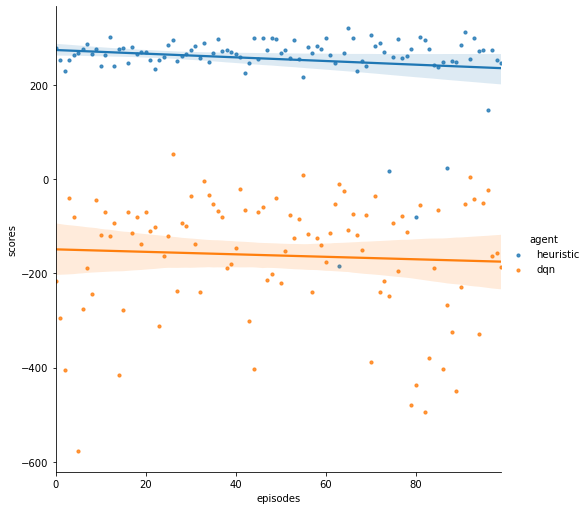

In [7]:
agents = ["heuristic", "dqn"]
scores = scores1 + scores2
sa.utils.plot_multi_scores(agents, scores)

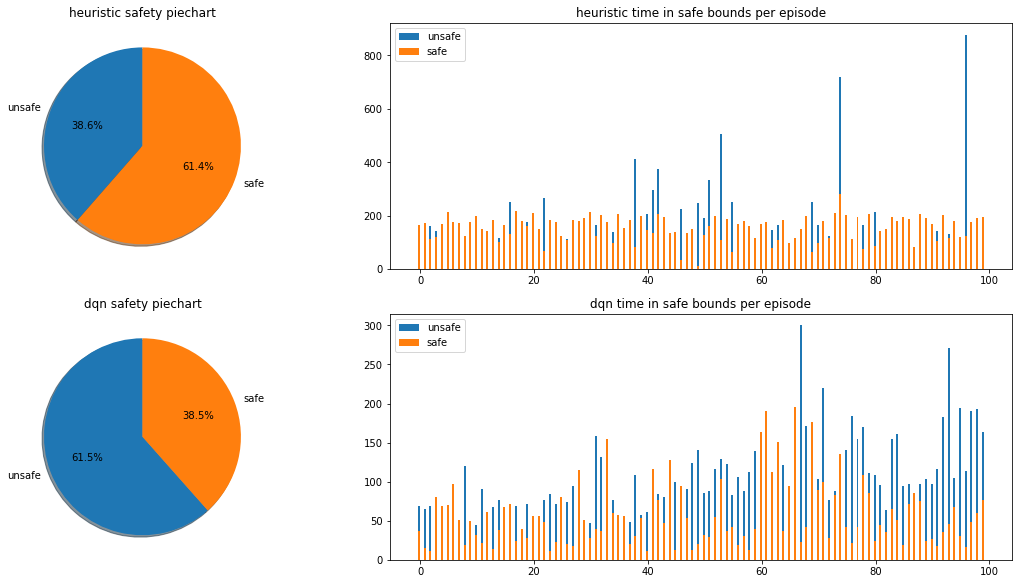

In [8]:
agents = {'heuristic': safety1, 'dqn': safety2}
sa.utils.plot_multi_safety(agents)

In [ ]:
agents = {'heuristic': safety1, 'dqn': safety2}

#######################################################

import itertools

    widths = [2, 3]
    heights = [2, 2]
    fig = plt.figure(constrained_layout=True, figsize=(15,8))
    spec = fig.add_gridspec(ncols=len(agents), nrows=len(agents), width_ratios=widths, height_ratios=heights)
    agent_v = list(agents.values())

    for row in range(len(agents)):
        agent_str = str(list(agents.keys())[row])
        for col in range(len(agents)):
            ax = fig.add_subplot(spec[row, col])
            if col == 0:
                labels = 'unsafe', 'safe'
                merged = list(itertools.chain.from_iterable(agent_v[row]))
                sizes = [merged.count(0), merged.count(1)]
                ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
                ax.set_title(agent_str + ' safety piechart')
            if col == 1:
                s = [(i.count(0), i.count(1)) for i in agent_v[row]]
                unsafe = [i[0] for i in s]
                safe = [i[1] for i in s]
                labels = [str(i) for i in range(len(agent_v[row]))]
                x = np.arange(len(labels))  # the label locations
                width = 0.35  # the width of the bars
                p1 = ax.bar(x - width/2, unsafe, width, label='unsafe')
                p2 = ax.bar(x - width/2, safe, width, label='safe')
                ax.legend()
                ax.set_title(agent_str + ' time in safe bounds per episode')
